# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import os,glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

delphesDir = os.path.abspath("./MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')


pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

Welcome to JupyROOT 6.24/06


### Load Recast Data

In [2]:
inputFiles = glob.glob('./DMSimp_vector_dijet_nwa/Events/run*/*.root')
inputDict = {}
for f in inputFiles:
    mMed,mDM = os.path.basename(f).split('_')[1:3]
    inputDict[eval(mMed)] = f
inputDict = dict(sorted(inputDict.items()))

In [3]:
deltaEta = {mMed : [] for mMed in inputDict}
mList = {mMed : [] for mMed in inputDict}
zboost = {mMed : [] for mMed in inputDict}

for mMed,inputFile in inputDict.items():
    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    npass = 0
    n_acc = 0
    total_xsec = 0.0
    for ievt in range(nevts):
        tree.GetEntry(ievt)
        weightPB = tree.Weight.At(1).Weight
        total_xsec += weightPB
        zpList = []
        zpDaughters = {}
        for iptc in range(tree.Particle.GetEntries()):
#             if iptc > 100:
#                 break
            p = tree.Particle.At(iptc)
#             print(iptc,':',p.PID,'->',p.D1,p.D2)
            if abs(p.PID) == 55 and (p.D1 != p.D2):
                zpList.append(p)
                zpDaughters[len(zpList)-1] = []
                for idaughter in range(p.D1,p.D2+1):
                    zpDaughters[len(zpList)-1].append(tree.Particle.At(idaughter))
                    
                                                      
        if len(zpList) != 1:
            print('More than one mediator found in event',ievt)
            break
        zp = zpList[0]
        mz = np.sqrt(zp.E**2 - zp.Px**2 - zp.Py**2 - zp.Pz**2)
        beta = np.sqrt(zp.Px**2 + zp.Py**2 + zp.Pz**2)/zp.E
        daughters = zpDaughters[0]
        if len(daughters) != 2:
            print('More than one mediator found in event',ievt)
            break

        if any(abs(d.PID) in [6,52] for d in daughters):
            continue
            
        npass += 1
        mList[mMed].append(mz)
        zboost[mMed].append(beta)
        dEta = abs(daughters[0].Eta-daughters[1].Eta)
        deltaEta[mMed].append(dEta)
        
        if dEta > 1.1:
            continue
        if any(abs(d.Eta) > 2.5 for d in daughters):
            continue
        n_acc += 1
        

    print('Mass = %1.0f' %mMed, 'Acceptance = %1.2f' %(float(n_acc)/npass))
    print('BR = ',float(npass)/nevts)
    print('Total xsec (pb) = %1.3e' %total_xsec)
    print('sigma*BR*Acc = %1.3e' %(total_xsec*n_acc/nevts))
    print()
    f.Close()
            

Mass = 2000 Acceptance = 0.40
BR =  1.0
Total xsec (pb) = 3.696e-06
sigma*BR*Acc = 1.469e-06

Mass = 3000 Acceptance = 0.41
BR =  1.0
Total xsec (pb) = 3.314e-07
sigma*BR*Acc = 1.345e-07

Mass = 4000 Acceptance = 0.40
BR =  1.0
Total xsec (pb) = 3.927e-08
sigma*BR*Acc = 1.587e-08

Mass = 5000 Acceptance = 0.40
BR =  1.0
Total xsec (pb) = 4.902e-09
sigma*BR*Acc = 1.973e-09

Mass = 6000 Acceptance = 0.42
BR =  1.0
Total xsec (pb) = 6.142e-10
sigma*BR*Acc = 2.570e-10



### Plot Jet Distributions

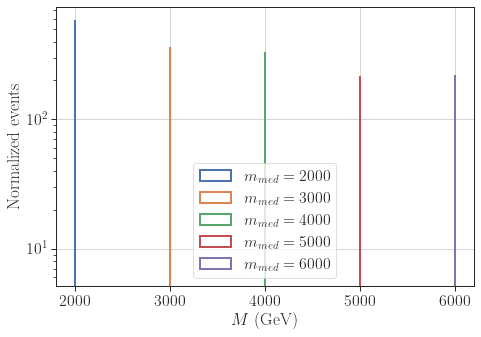

In [7]:
colors = sns.color_palette('deep',10)
fig = plt.figure(figsize=(7,5))

nplots = 0
for mMed,mvals in mList.items():    
    h,_,_ = plt.hist(mvals,label=r'$m_{med} = %1.0f$' %mMed,histtype='step',
                  linewidth=2,bins=50,density=True,color=colors[nplots])
    nplots += 1
    

plt.legend()
plt.yscale('log')
plt.grid()

plt.xlabel(r'$M$ (GeV)')
plt.ylabel('Normalized events')
plt.tight_layout()
plt.show()

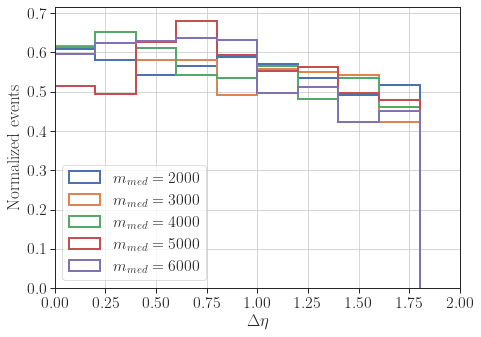

In [8]:
colors = sns.color_palette('deep',10)
fig = plt.figure(figsize=(7,5))

nplots = 0
for mMed,mvals in deltaEta.items():    
    h,_,_ = plt.hist(mvals,label=r'$m_{med} = %1.0f$' %mMed,histtype='step',
                  linewidth=2,bins=np.arange(0.,2.,0.2),density=True,color=colors[nplots])
    nplots += 1
    


plt.xlim(0.,2.)
# plt.yscale('log')
plt.grid()
plt.legend(loc='lower left')
plt.xlabel(r'$\Delta \eta$')
plt.ylabel('Normalized events')
plt.tight_layout()
plt.show()

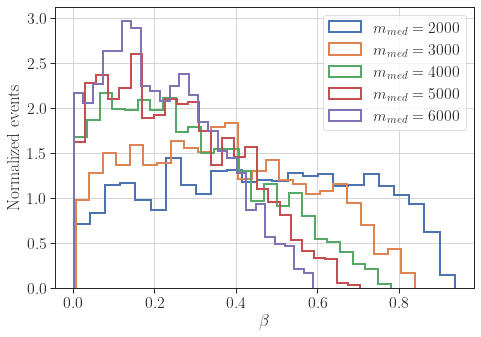

In [9]:
colors = sns.color_palette('deep',10)
fig = plt.figure(figsize=(7,5))

nplots = 0
for mMed,mvals in zboost.items():    
    h,_,_ = plt.hist(mvals,label=r'$m_{med} = %1.0f$' %mMed,histtype='step',
                  linewidth=2,bins=25,density=True,color=colors[nplots])
    nplots += 1
    

plt.legend()
# plt.yscale('log')
plt.grid()

plt.xlabel(r'$\beta$')
plt.ylabel('Normalized events')
plt.tight_layout()
plt.show()